
## Cancer prediction using RNA Sequence Analysis
=============================================================
***
- ***Importing required libraries***

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy import stats
%matplotlib inline
from collections import Counter
from sklearn.decomposition import PCA
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score , roc_auc_score, roc_curve, auc, pairwise_distances
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.base import clone
from itertools import combinations 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder , StandardScaler
from sklearn import feature_selection, model_selection, preprocessing
import math
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier

***
- ***Importing and Sampling data***

In [2]:
df = pd.read_csv("data.csv", header=0)
df = df.rename(columns={"Unnamed: 0": "Patient ID"})
df_label = pd.read_csv("labels.csv", header=0)
df_label = df_label.rename(columns={"Unnamed: 0": "Patient ID"})

In [3]:
df.sample(5)

,Patient ID,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
436,sample_436,0.0,3.083418,1.864414,7.373474,9.659152,0.0,7.214329,0.340505,0.0,...,6.375111,10.891488,10.262565,8.349118,9.795932,10.671276,9.236615,9.480338,5.336448,0.000000
724,sample_724,0.0,2.154097,1.536948,6.765561,9.269557,0.0,6.483430,0.394953,0.0,...,6.452643,8.805660,9.909356,3.384851,9.812153,11.784279,10.144633,9.290745,4.905317,0.000000
86,sample_86,0.0,1.912841,4.153797,8.426726,10.833459,0.0,6.126296,0.460795,0.0,...,5.418349,8.601942,9.880768,5.662949,9.396874,10.227628,10.013783,10.894901,8.275696,0.460795
55,sample_55,0.0,2.350384,3.249369,6.293150,10.561775,0.0,8.414148,1.555767,0.0,...,5.647982,8.958857,10.530894,8.247652,10.111657,11.744279,9.587796,9.081880,8.538527,0.404140
314,sample_314,0.0,1.212445,0.000000,6.508555,10.328484,0.0,6.232841,0.000000,0.0,...,4.968022,7.066627,8.876419,7.372134,9.606479,12.483781,8.148660,10.214210,4.214467,0.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Patient ID to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [5]:
print("Dataset Shape : ",df.shape) 
print("Dataset Size : ",df.size) 

Dataset Shape :  (801, 20532)
Dataset Size :  16446132


***
- ***Importing and Sampling data***

In [6]:
df.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


In [7]:
df_label.sample(5)

,Patient ID,Class
335,sample_335,PRAD
324,sample_324,BRCA
440,sample_440,LUAD
20,sample_20,BRCA
119,sample_119,BRCA


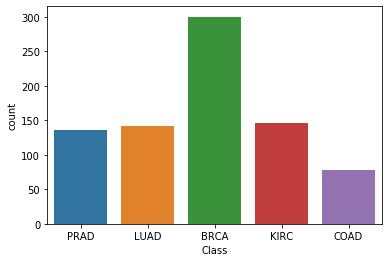

In [8]:
sns.countplot(df_label['Class'])
plt.show()

In [9]:
df_label.describe()

,Patient ID,Class
count,801,801
unique,801,5
top,sample_627,BRCA
freq,1,300


In [10]:
print(f'Number of patients: {len(df)}')

Number of patients: 801


In [11]:
print(f"Percentage of each type of cancer: \n{df_label['Class'].value_counts(normalize = True)*100}")

Percentage of each type of cancer: 
BRCA    37.453184
KIRC    18.227216
LUAD    17.602996
PRAD    16.978777
COAD     9.737828
Name: Class, dtype: float64


In [12]:
print(f'Number of null values: {df.isnull().sum().sum()}')

Number of null values: 0


In [13]:
df = df.assign(Class = pd.Series(df_label['Class'].values))

In [14]:
a = df.shape
a = a[0] * a[1]
b = (df != 0).sum(1).sum()
sparsity = 1 - (b/a)
print(f'Percentage of Sparsity of our Dataset: {(sparsity*100)}')


Percentage of Sparsity of our Dataset: 14.216170273205343


a - Total number of elements in the dataframe
b - Total number of non 0 elements in the dataframe
Sparsity + Density = 1
Sparsity = Ratio of 0 Elements to the total number of elements (A)

In [15]:
labelenc = preprocessing.LabelEncoder()
labelenc.fit(df['Class'].unique())
labelenc.classes_

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

In [16]:
labelenc.inverse_transform([0, 1, 2, 3, 4])
df['Class'] = labelenc.transform(df['Class'])
s = df['Class'].unique()
s.sort()
print(s)

[0 1 2 3 4]


In [17]:
X = np.array(df.iloc[:, 1:].values)
y = np.array(df.iloc[:, -1].values) 

***
### Train-Test split in 7:3 ratio

In [18]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=1)


***
### Learning curve for Decision Tree

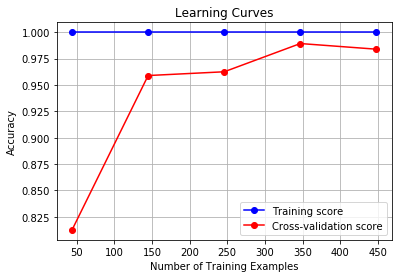

In [19]:
classifier = DecisionTreeClassifier(criterion='entropy', random_state=5, class_weight=None)
plt.figure()
plt.title("Learning Curves")
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy")
plt.grid()
train_sizes, train_scores, test_scores = learning_curve(classifier, X_train, y_train, cv=5, random_state=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Cross-validation score")
plt.legend(loc="best")

In [20]:
print(f"Population counts: {Counter(y_train)}")

Population counts: Counter({0: 210, 2: 108, 4: 95, 3: 94, 1: 53})


***
### Handling the class imbalance problem with SMOTE

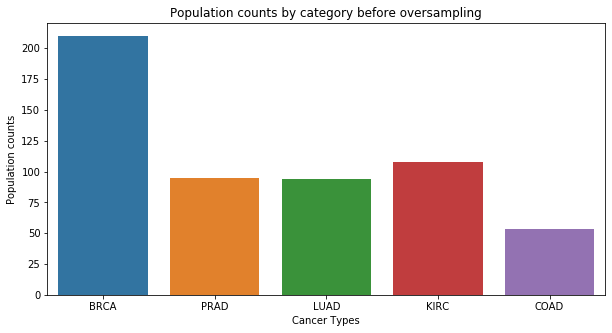

In [21]:
plt.figure(figsize=(10, 5))
sns.countplot(labelenc.inverse_transform(y_train)).set_title("Population counts by category before oversampling")
plt.xlabel("Cancer Types")
plt.ylabel("Population counts")
plt.show()

In [22]:
smote = SMOTE(sampling_strategy ='auto', k_neighbors=5, random_state=5)
X_smote, y_smote = smote.fit_resample(X_train, y_train)           
print(f"Population counts after resampling {Counter(y_smote)}")

Population counts after resampling Counter({0: 210, 4: 210, 3: 210, 2: 210, 1: 210})


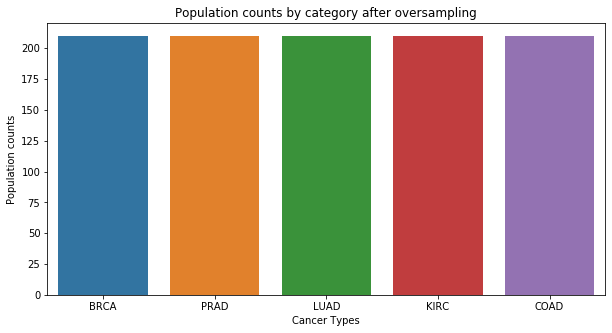

In [23]:
plt.figure(figsize=(10, 5))
sns.countplot(labelenc.inverse_transform(y_smote)).set_title("Population counts by category after oversampling")
plt.xlabel("Cancer Types")
plt.ylabel("Population counts")
plt.show()


***
### Feature Engineering
- ***Feature Scaling***

In [24]:
stdsc = StandardScaler()

X_train = stdsc.fit_transform(X_smote)
X_test = stdsc.transform(X_test)
y_train = y_smote
X_train[0:5]

array([[-0.23577482, -0.15489153, -1.53179447, ...,  1.70569028,
        -0.29221236, -1.41421356],
       [-0.23577482,  1.0261741 ,  0.80452868, ..., -1.02707039,
        -0.29221236, -1.41421356],
       [-0.23577482,  1.65669236,  1.28963081, ...,  0.49990216,
        -0.29221236,  1.41421356],
       [-0.23577482,  0.95786001, -0.55403461, ...,  0.1190927 ,
        -0.29221236, -1.41421356],
       [-0.23577482, -1.60459312, -0.15749521, ...,  0.40979872,
        -0.29221236,  1.41421356]])

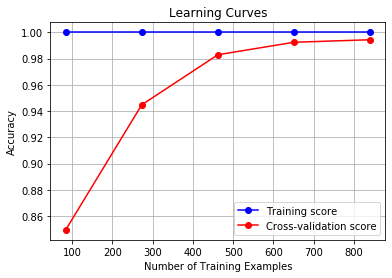

In [25]:
classifier = DecisionTreeClassifier(criterion='entropy', random_state=5, class_weight=None)
plt.figure()
plt.title("Learning Curves")
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy")
plt.grid()
train_sizes, train_scores, test_scores = learning_curve(classifier, X_train, y_train, cv=5, random_state=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Cross-validation score")
plt.legend(loc="best")

- ***Feature Importances***


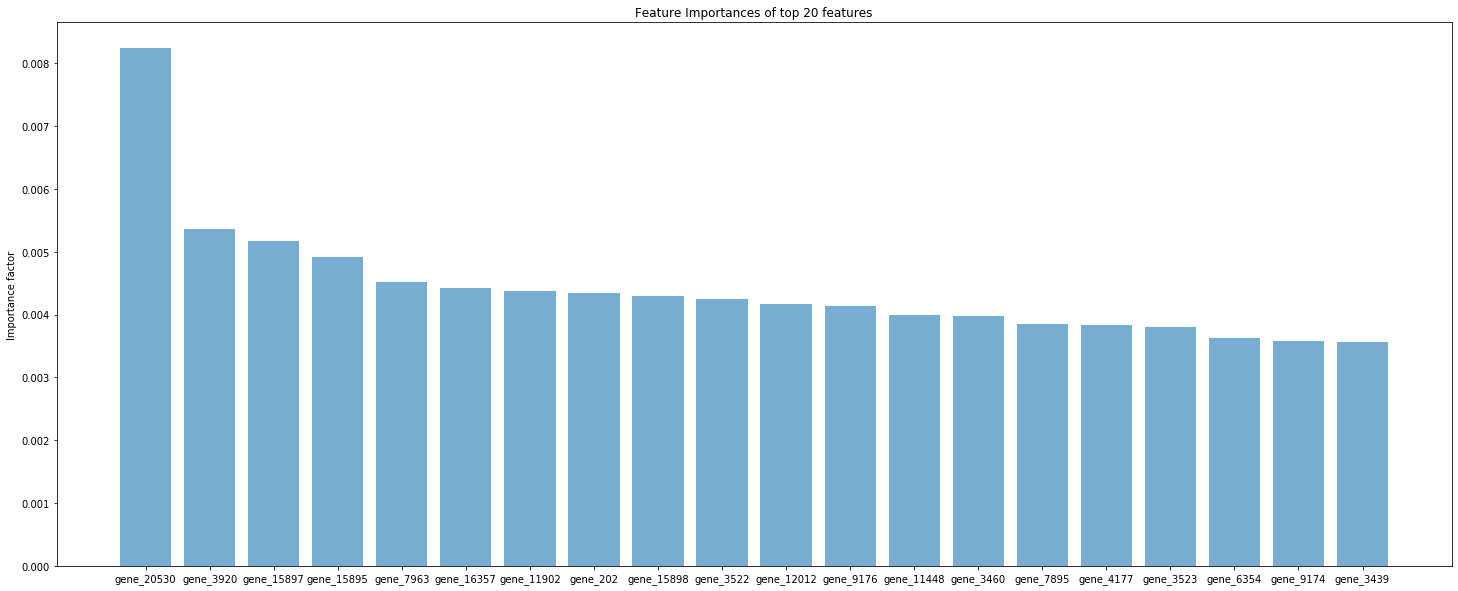

In [26]:
rnd_clf = RandomForestClassifier(n_estimators=1500, n_jobs=3)
rnd_clf.fit(X_train, y_train)
list_features = sorted(zip(rnd_clf.feature_importances_, df.columns), reverse=True, key = lambda x: x[0])
top_features = {}
for row in list_features[:20]:
    top_features[row[1]] = row[0]
plt.figure(figsize=(25, 10))
plt.bar(top_features.keys(), top_features.values(), align='center', alpha=0.6)
plt.ylabel('Importance factor')
plt.title('Feature Importances of top 20 features')
plt.show()


- ***Correlation Heatmap for the most important features***

Text(0.5, 1, 'Correlation heatmap for the top 20 important features')

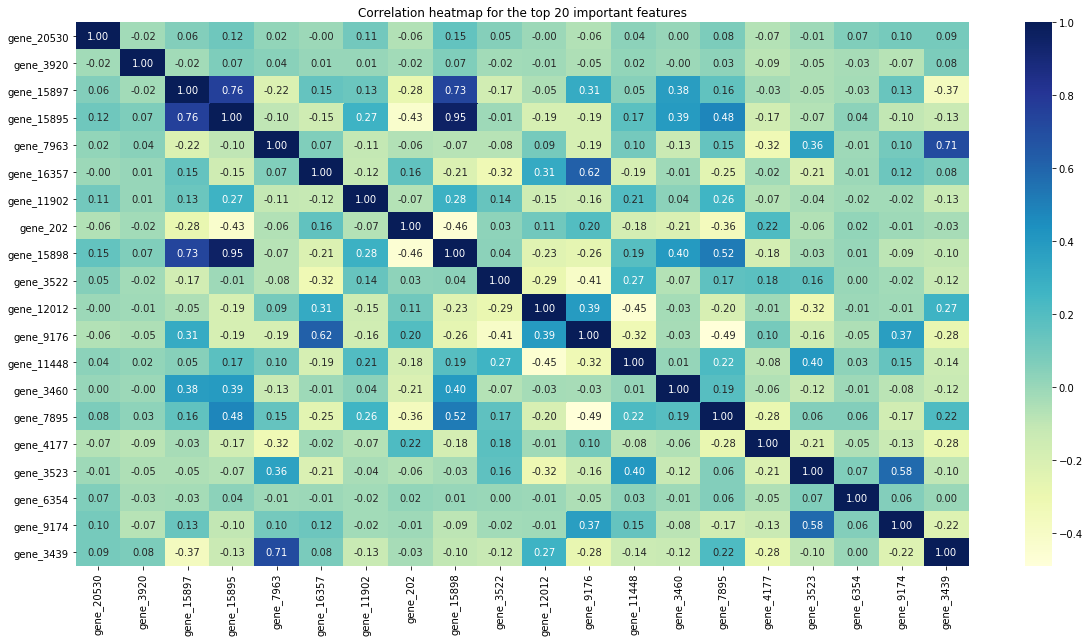

In [27]:
corr = df[top_features.keys()].corr()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corr,annot=True, fmt='.2f',cmap="YlGnBu").set_title("Correlation heatmap for the top 20 important features")


- ***Masked heatmap***

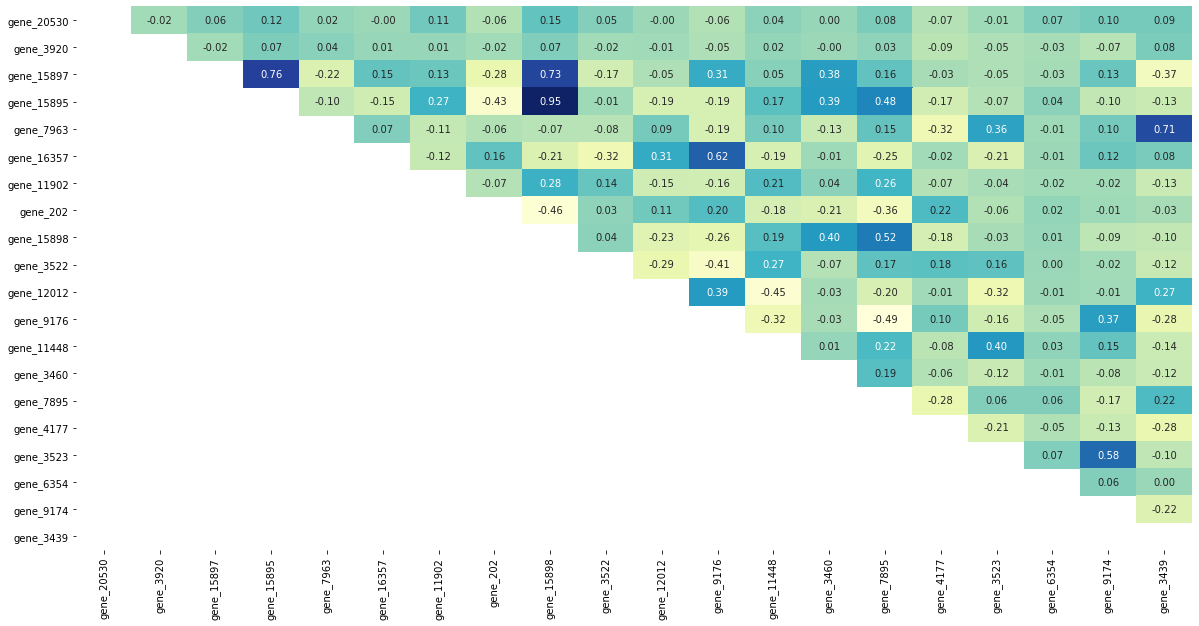

In [28]:


fig, ax = plt.subplots(figsize=(20,10))

mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True

sns.heatmap(corr, annot=True,fmt = '.2f', cmap="YlGnBu",mask=mask, linecolor='b', cbar = False)


In [29]:
corr

,gene_20530,gene_3920,gene_15897,gene_15895,gene_7963,gene_16357,gene_11902,gene_202,gene_15898,gene_3522,gene_12012,gene_9176,gene_11448,gene_3460,gene_7895,gene_4177,gene_3523,gene_6354,gene_9174,gene_3439
gene_20530,1.000000,-0.024297,0.059069,0.117050,0.021874,-0.002657,0.107076,-0.063359,0.154957,0.052166,-0.003178,-0.064504,0.036813,0.004861,0.077835,-0.065993,-0.008369,0.068182,0.095213,0.093984
gene_3920,-0.024297,1.000000,-0.019113,0.070136,0.044440,0.005832,0.006767,-0.024447,0.067003,-0.019204,-0.013092,-0.051392,0.018514,-0.002522,0.028373,-0.088335,-0.051958,-0.034964,-0.073741,0.079917
gene_15897,0.059069,-0.019113,1.000000,0.756118,-0.215704,0.149042,0.130402,-0.282738,0.734601,-0.165316,-0.052596,0.313051,0.049795,0.378949,0.157253,-0.034392,-0.052900,-0.029057,0.134244,-0.366370
gene_15895,0.117050,0.070136,0.756118,1.000000,-0.098151,-0.153051,0.266540,-0.426620,0.954592,-0.008913,-0.192834,-0.191702,0.173410,0.391193,0.477286,-0.166844,-0.065397,0.037515,-0.102300,-0.131603
gene_7963,0.021874,0.044440,-0.215704,-0.098151,1.000000,0.066225,-0.107067,-0.064913,-0.073230,-0.075611,0.093758,-0.192523,0.100998,-0.129421,0.147340,-0.316916,0.356692,-0.008725,0.102735,0.712840
gene_16357,-0.002657,0.005832,0.149042,-0.153051,0.066225,1.000000,-0.115077,0.157562,-0.210937,-0.318322,0.313640,0.620845,-0.188363,-0.010280,-0.249340,-0.024385,-0.207189,-0.005875,0.121623,0.081429
gene_11902,0.107076,0.006767,0.130402,0.266540,-0.107067,-0.115077,1.000000,-0.065314,0.281695,0.140657,-0.151401,-0.160360,0.207458,0.037207,0.255361,-0.067655,-0.041025,-0.021378,-0.019417,-0.128355
gene_202,-0.063359,-0.024447,-0.282738,-0.426620,-0.064913,0.157562,-0.065314,1.000000,-0.459678,0.029563,0.113129,0.199232,-0.176205,-0.210708,-0.361809,0.218678,-0.061211,0.019886,-0.012049,-0.034080
gene_15898,0.154957,0.067003,0.734601,0.954592,-0.073230,-0.210937,0.281695,-0.459678,1.000000,0.038399,-0.234609,-0.262315,0.190188,0.398543,0.517275,-0.180508,-0.034129,0.008388,-0.092160,-0.102584
gene_3522,0.052166,-0.019204,-0.165316,-0.008913,-0.075611,-0.318322,0.140657,0.029563,0.038399,1.000000,-0.290796,-0.408626,0.265553,-0.069334,0.167560,0.175920,0.162487,0.003458,-0.023115,-0.122347


In [30]:
corr.sum(axis=0)

gene_20530    1.656723
gene_3920     0.917920
gene_15897    2.644341
gene_15895    2.706426
gene_7963     1.364641
gene_16357    1.030722
gene_11902    1.556114
gene_202     -0.505082
gene_15898    2.695492
gene_3522     0.534179
gene_12012    0.221630
gene_9176     0.344077
gene_11448    1.494797
gene_3460     1.522698
gene_7895     1.821228
gene_4177    -0.580824
gene_3523     1.208299
gene_6354     1.140725
gene_9174     1.676667
gene_3439     0.429774
dtype: float64

In [31]:
corr.sum(axis=1)

gene_20530    1.656723
gene_3920     0.917920
gene_15897    2.644341
gene_15895    2.706426
gene_7963     1.364641
gene_16357    1.030722
gene_11902    1.556114
gene_202     -0.505082
gene_15898    2.695492
gene_3522     0.534179
gene_12012    0.221630
gene_9176     0.344077
gene_11448    1.494797
gene_3460     1.522698
gene_7895     1.821228
gene_4177    -0.580824
gene_3523     1.208299
gene_6354     1.140725
gene_9174     1.676667
gene_3439     0.429774
dtype: float64

- ***Dimensionality Reduction with PCA***

In [32]:
max1 = 0
max2 = 0
# Using Pipeline to automate learning process    
for i in range(2, 6):
    pipe = Pipeline([('pca', PCA(n_components=i, random_state=0)),('clf', DecisionTreeClassifier())])
    pipe.fit(X_train, y_train)
    if(max1<pipe.score(X_test, y_test)):
        max1 = pipe.score(X_test, y_test)
        max2 = i

pca = PCA(n_components=max2)
principal_component = pca.fit_transform(X_train)
principal_df = pd.DataFrame(data=principal_component)
y_train_pca = pd.DataFrame(data = labelenc.inverse_transform(y_train), columns = ["Class"])
concat_df = pd.concat([principal_df, y_train_pca], axis=1)

***
- ***PCA treated dataset visualization***


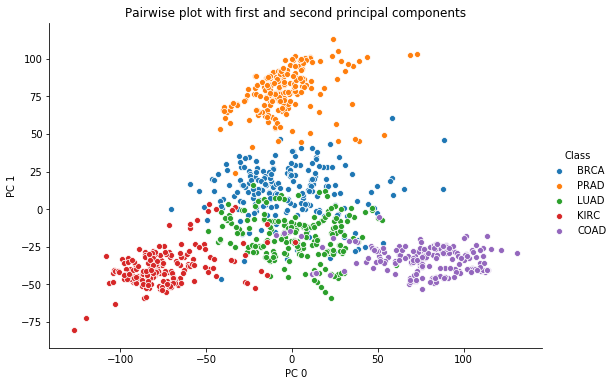

In [33]:
# As it is 2-D, hence only two PCA components can be shown.
sns.pairplot(x_vars = 0, y_vars = 1,data=concat_df, hue="Class",height=5,aspect=1.5)
plt.title("Pairwise plot with first and second principal components")
plt.xlabel("PC 0")
plt.ylabel("PC 1")
plt.show()

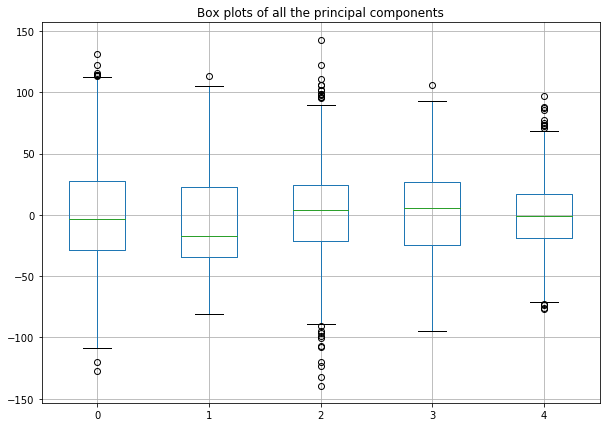

In [34]:
concat_df.boxplot(figsize= (10,7))
plt.title("Box plots of all the principal components")
plt.show()

In [35]:
concat_df.head()

,0,1,2,3,4,Class
0,6.245800,7.469680,-80.080642,11.399833,32.390292,BRCA
1,0.370657,38.976016,-50.551125,7.569441,47.241770,BRCA
2,-19.478581,62.411705,-16.822942,14.091392,-15.265436,PRAD
3,30.454246,0.977979,-54.415884,-11.276924,54.864544,BRCA
4,-10.096630,53.881737,32.790279,-21.832190,1.000200,PRAD


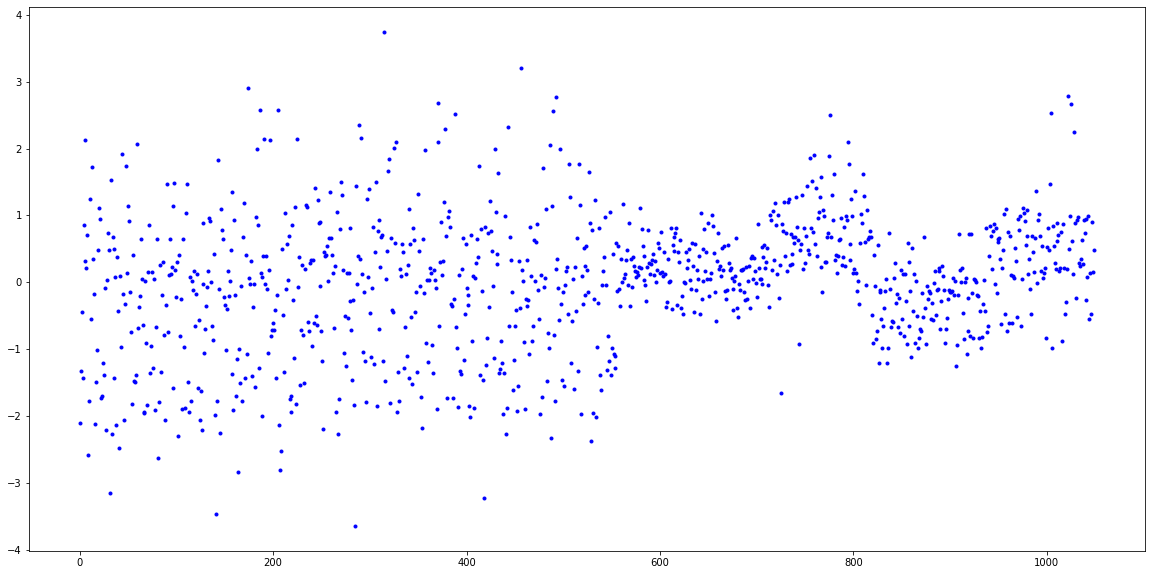

In [36]:
plt.figure(figsize=(20,10))
values = (concat_df[2].values).reshape(-1, 1)
scaled = StandardScaler().fit_transform(values)
plt.plot(scaled, 'b.')
plt.show()

***
- ***t-SNE treated dataset visualization***

In [37]:
tsne = TSNE(n_components=2, random_state=0)
principal_component1 = tsne.fit_transform(X_train)
principal_df = pd.DataFrame(data=principal_component1)
y_train_tsne = pd.DataFrame(data = labelenc.inverse_transform(y_train), columns = ["Class"])
concat_df1 = pd.concat([principal_df, y_train_tsne], axis=1)


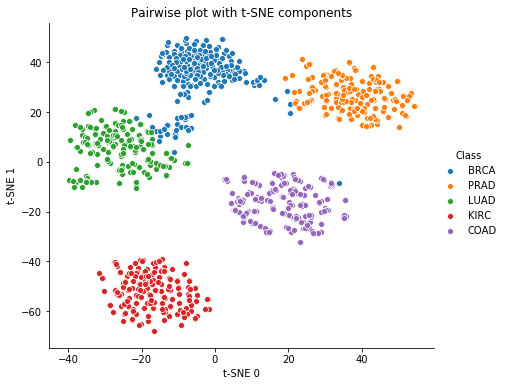

In [38]:
sns.pairplot(x_vars=0, y_vars=1, data=concat_df1, hue="Class",height=5,aspect=1.2)
plt.title("Pairwise plot with t-SNE components")
plt.xlabel("t-SNE 0")
plt.ylabel("t-SNE 1")
plt.show()

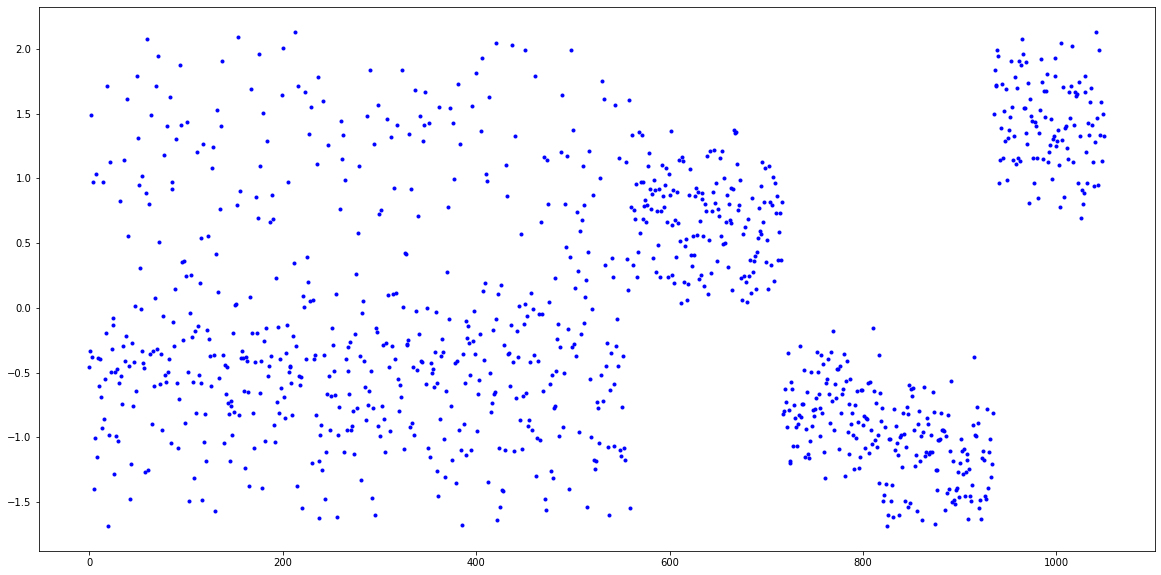

In [39]:
plt.figure(figsize=(20,10))
values = (concat_df1[0].values).reshape(-1, 1)
scaled = StandardScaler().fit_transform(values)
plt.plot(scaled, 'b.')
plt.show()

In [40]:
StandardScaler().fit_transform([concat_df[0].values])

array([[0., 0., 0., ..., 0., 0., 0.]])

***
### Model Selection
***

##### List of Models used : 

In [41]:
ml_alg = [ensemble.RandomForestClassifier(),naive_bayes.BernoulliNB(),naive_bayes.GaussianNB(),DecisionTreeClassifier(),svm.LinearSVC()]
ml_alg_predict = df.Class

- ***Modelling on PCA Data***

In [42]:
ml_alg_columns = ['Model Name','Train Accuracy Mean', 'Validation Accuracy Mean','Time']
ml_alg_compare_pca = pd.DataFrame(columns = ml_alg_columns)
row_index = 0
models_res={}
for alg in ml_alg:
    ml_alg_name = alg.__class__.__name__
    
    ml_alg_compare_pca.loc[row_index, 'Model Name'] = ml_alg_name
    pipe = Pipeline([('pca', PCA(n_components=max2)),('clf', alg)])
    
    cv_results = model_selection.cross_validate(pipe, X_train, y_train, cv=5, n_jobs=3, verbose=False, return_train_score=True)
    models_res[ml_alg_name] = cv_results
    ml_alg_compare_pca.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
    ml_alg_compare_pca.loc[row_index, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
    ml_alg_compare_pca.loc[row_index, 'Validation Accuracy Mean'] = cv_results['test_score'].mean()   
    pipe.fit(X_train, y_train)
    ml_alg_predict[ml_alg_name] = pipe.predict(X_test)
    y_true, y_pred = y_test, ml_alg_predict[ml_alg_name]
    results = metrics.classification_report(y_true,y_pred)
    print(ml_alg_name)
    print(results)
    ml_alg_compare_pca.loc[row_index, 'Test F1 Score'] = classification_report(y_true,y_pred, output_dict=True)['weighted avg']['f1-score']
    row_index+=1
    
ml_alg_compare_pca.sort_values(by = ['Test F1 Score'], ascending = False, inplace = True)
ml_alg_compare_pca

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        90
           1       0.96      0.92      0.94        25
           2       1.00      0.97      0.99        38
           3       0.92      0.94      0.93        47
           4       1.00      0.98      0.99        41

    accuracy                           0.96       241
   macro avg       0.97      0.96      0.96       241
weighted avg       0.96      0.96      0.96       241

BernoulliNB
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        90
           1       1.00      0.88      0.94        25
           2       0.94      0.79      0.86        38
           3       0.72      0.83      0.77        47
           4       0.80      0.78      0.79        41

    accuracy                           0.84       241
   macro avg       0.86      0.83      0.84       241
weighted avg       0.85      0.84      0.8

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC
              precision    recall  f1-score   support

           0       0.99      0.87      0.92        90
           1       0.92      0.92      0.92        25
           2       1.00      0.92      0.96        38
           3       0.77      0.98      0.86        47
           4       0.98      1.00      0.99        41

    accuracy                           0.93       241
   macro avg       0.93      0.94      0.93       241
weighted avg       0.94      0.93      0.93       241



,Model Name,Train Accuracy Mean,Validation Accuracy Mean,Time,Test F1 Score
0,RandomForestClassifier,1,0.98381,7.52796,0.962765
2,GaussianNB,0.964286,0.96381,5.78223,0.934815
3,DecisionTreeClassifier,1,0.970476,3.82846,0.930016
4,LinearSVC,0.899286,0.90381,5.54574,0.927106
1,BernoulliNB,0.897857,0.892381,4.22299,0.839721


- ***Modelling on t-SNE Data***

In [43]:
size_train = X_train.shape[0]
X = np.vstack((X_train,X_test))
X_tsne = TSNE(n_components=2, random_state=0).fit_transform( X ) 
X_train_tsne = X_tsne[0:size_train,:]
X_test_tsne  = X_tsne[size_train:,:]

In [44]:
ml_alg_columns = ['Model Name','Train Accuracy Mean', 'Validation Accuracy Mean','Time']
ml_alg_compare_tsne = pd.DataFrame(columns = ml_alg_columns)
models_res = {}
row_index = 0
for alg in ml_alg:
    ml_alg_name = alg.__class__.__name__
    
    ml_alg_compare_tsne.loc[row_index, 'Model Name'] = ml_alg_name
    cv_results = model_selection.cross_validate(alg, X_train_tsne, y_train, cv=5, n_jobs=3, verbose=False, return_train_score=True)
    models_res[ml_alg_name] = cv_results
    ml_alg_compare_tsne.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
    ml_alg_compare_tsne.loc[row_index, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
    ml_alg_compare_tsne.loc[row_index, 'Validation Accuracy Mean'] = cv_results['test_score'].mean()   
    alg.fit(X_train_tsne, y_train)
    ml_alg_predict[ml_alg_name] = alg.predict(X_test_tsne)
    y_true, y_pred = y_test, ml_alg_predict[ml_alg_name]
    print(ml_alg_name)
    print(results)
    ml_alg_compare_tsne.loc[row_index, 'Test F1 Score'] = classification_report(y_true,y_pred, output_dict=True)['weighted avg']['f1-score']
    row_index+=1

ml_alg_compare_tsne.sort_values(by = ['Test F1 Score'], ascending = False, inplace = True)
ml_alg_compare_tsne


RandomForestClassifier
              precision    recall  f1-score   support

           0       0.99      0.87      0.92        90
           1       0.92      0.92      0.92        25
           2       1.00      0.92      0.96        38
           3       0.77      0.98      0.86        47
           4       0.98      1.00      0.99        41

    accuracy                           0.93       241
   macro avg       0.93      0.94      0.93       241
weighted avg       0.94      0.93      0.93       241

BernoulliNB
              precision    recall  f1-score   support

           0       0.99      0.87      0.92        90
           1       0.92      0.92      0.92        25
           2       1.00      0.92      0.96        38
           3       0.77      0.98      0.86        47
           4       0.98      1.00      0.99        41

    accuracy                           0.93       241
   macro avg       0.93      0.94      0.93       241
weighted avg       0.94      0.93      0.9

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LinearSVC
              precision    recall  f1-score   support

           0       0.99      0.87      0.92        90
           1       0.92      0.92      0.92        25
           2       1.00      0.92      0.96        38
           3       0.77      0.98      0.86        47
           4       0.98      1.00      0.99        41

    accuracy                           0.93       241
   macro avg       0.93      0.94      0.93       241
weighted avg       0.94      0.93      0.93       241



/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,Model Name,Train Accuracy Mean,Validation Accuracy Mean,Time,Test F1 Score
2,GaussianNB,0.99,0.992381,0.00127459,0.995840
0,RandomForestClassifier,1,0.994286,0.25889,0.991657
3,DecisionTreeClassifier,1,0.995238,0.00110521,0.991657
4,LinearSVC,0.988571,0.986667,0.0562699,0.987557
1,BernoulliNB,0.765714,0.765714,0.002213,0.675554


- ***Modelling on PCA + t-SNE Data***

In [45]:
pca = PCA(n_components=.95)
X_train_practice_pca = pca.fit_transform(X_train)
tsne = TSNE(n_components=2, random_state=0)
principal_component1 = tsne.fit_transform(X_train_practice_pca)
principal_df = pd.DataFrame(data=principal_component1)
y_train_tsne = pd.DataFrame(data = labelenc.inverse_transform(y_train), columns = ["Class"])
concat_df1 = pd.concat([principal_df, y_train_tsne], axis=1)

In [46]:
size_train = X_train.shape[0]
X = np.vstack((X_train,X_test))
pca = PCA(n_components=.95)
X_practice_pca = pca.fit_transform(X)
X_tsne = TSNE(n_components=2, random_state=0).fit_transform( X_practice_pca ) 
X_train_tsne = X_tsne[0:size_train,:]
X_test_tsne  = X_tsne[size_train:,:]

In [47]:
ml_alg_columns = ['Model Name','Train Accuracy Mean', 'Validation Accuracy Mean','Time']
ml_alg_compare_tsne = pd.DataFrame(columns = ml_alg_columns)
row_index = 0
models_res={}
warnings.simplefilter("ignore")
for alg in ml_alg:
    ml_alg_name = alg.__class__.__name__
    
    ml_alg_compare_tsne.loc[row_index, 'Model Name'] = ml_alg_name
    cv_results = model_selection.cross_validate(alg, X_train_tsne, y_train, cv=5, n_jobs=-1, verbose=False, return_train_score=True)
    models_res[ml_alg_name] = cv_results
    ml_alg_compare_tsne.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
    ml_alg_compare_tsne.loc[row_index, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
    ml_alg_compare_tsne.loc[row_index, 'Validation Accuracy Mean'] = cv_results['test_score'].mean()   
    alg.fit(X_train_tsne, y_train)
    ml_alg_predict[ml_alg_name] = alg.predict(X_test_tsne)
    y_true, y_pred = y_test, ml_alg_predict[ml_alg_name]
    results = metrics.classification_report(y_true,y_pred)
    print(ml_alg_name)
    print(results)
    ml_alg_compare_tsne.loc[row_index, 'Test F1 Score'] = classification_report(y_true,y_pred, output_dict=True)['weighted avg']['f1-score']
    row_index+=1

ml_alg_compare_tsne.sort_values(by = ['Test F1 Score'], ascending = False, inplace = True)
ml_alg_compare_tsne


RandomForestClassifier
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        38
           3       1.00      0.98      0.99        47
           4       1.00      1.00      1.00        41

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241

BernoulliNB
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.96      1.00      0.98        25
           2       0.95      1.00      0.97        38
           3       0.57      0.98      0.72        47
           4       0.41      0.95      0.57        41

    accuracy                           0.61       241
   macro avg       0.58      0.79      0.65       241
weighted avg       0.43      0.61      0.4

,Model Name,Train Accuracy Mean,Validation Accuracy Mean,Time,Test F1 Score
0,RandomForestClassifier,1,1,0.701316,0.995840
3,DecisionTreeClassifier,1,1,0.00130515,0.995840
2,GaussianNB,1,1,0.00139098,0.991663
4,LinearSVC,0.995476,0.999048,0.0593134,0.991663
1,BernoulliNB,0.750476,0.750476,0.00859642,0.494180
